## Test German dataset
- Document of dataset: 
    + https://aif360.readthedocs.io/en/stable/modules/generated/aif360.sklearn.datasets.fetch_german.html#aif360.sklearn.datasets.fetch_german
    + https://archive.ics.uci.edu/dataset/144/statlog+german+credit+data


In [24]:
# Custom imports
# import my_helper # my helper functions
from TabResNet import TabResNet 
from MLP import MLP

# General imports
from IPython.display import Markdown, display, clear_output
from functools import partial
import pathlib
import numpy as np
import pandas as pd

# DL imports
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score, precision_score
from sklearn.model_selection import train_test_split

# Choose the fairness metric
from fairlearn.metrics import (
    MetricFrame,
    count,
    false_negative_rate,
    false_positive_rate,
    selection_rate,
)

# Some "difference" metrics (as in Nils' paper)
# All ranges are [0,1] -> no need to scale 
from fairlearn.metrics import (
    demographic_parity_difference,
    equalized_odds_difference,
    true_positive_rate_difference,
    false_positive_rate_difference,
)

torch.manual_seed(27)
clear_output()
np.random.seed(27)

## Data Loading

In [58]:
# ---------------------------
# Data Loading and Preparation
# ---------------------------
from aif360.sklearn.datasets import fetch_german

X, y = fetch_german()


# The dataset and target labels have 3 index groups: sex, age, and foreign_worker -> Different from the previous datasets
# Now clear those indices to go back to the same format with previous datasets
X.reset_index(drop=True, inplace=True)
y.reset_index(drop=True, inplace=True)

# Binarize labels
y = y.map({'good': 1, 'bad': 0})


In [59]:
y = y.to_numpy(dtype=int)

In [60]:
# Add binary_age column based on the condition, value = aged if age >= 25 else young
X['age_group'] = X['age'].apply(lambda x: 'aged' if x >= 25 else 'young')

# X['age_group'] = (X['age'] >= 25)

In [61]:
y_df = pd.DataFrame(y)
print(y_df.value_counts(normalize=True))

0
1    0.7
0    0.3
Name: proportion, dtype: float64


## Data Preprocessing

### Label Encoding

In [7]:
X_copy = X.copy()
categorical_cols = X_copy.select_dtypes(include=['object', 'category']).columns

In [8]:
from sklearn.preprocessing import LabelEncoder
label_mappings = {}
# Apply LabelEncoder to each column and store mappings
for col in categorical_cols:
    le = LabelEncoder()
    X_copy[col] = le.fit_transform(X_copy[col])
    label_mappings[col] = dict(zip(le.classes_, le.transform(le.classes_)))

# Show mappings
for col, mapping in label_mappings.items():
    print(f"\nEncoded mapping for '{col}':")
    for original, encoded in mapping.items():
        print(f"  {original} → {encoded}")


Encoded mapping for 'checking_status':
  0<=X<200 → 0
  <0 → 1
  >=200 → 2
  no checking → 3

Encoded mapping for 'credit_history':
  all paid → 0
  critical/other existing credit → 1
  delayed previously → 2
  existing paid → 3
  no credits/all paid → 4

Encoded mapping for 'purpose':
  business → 0
  domestic appliance → 1
  education → 2
  furniture/equipment → 3
  new car → 4
  other → 5
  radio/tv → 6
  repairs → 7
  retraining → 8
  used car → 9

Encoded mapping for 'savings_status':
  100<=X<500 → 0
  500<=X<1000 → 1
  <100 → 2
  >=1000 → 3
  no known savings → 4

Encoded mapping for 'employment':
  1<=X<4 → 0
  4<=X<7 → 1
  <1 → 2
  >=7 → 3
  unemployed → 4

Encoded mapping for 'other_parties':
  co applicant → 0
  guarantor → 1
  none → 2

Encoded mapping for 'property_magnitude':
  car → 0
  life insurance → 1
  no known property → 2
  real estate → 3

Encoded mapping for 'other_payment_plans':
  bank → 0
  none → 1
  stores → 2

Encoded mapping for 'housing':
  for free → 0

In [9]:
X_encoded = X_copy.copy()

In [10]:
X_le = X_encoded.drop(columns=['sex'])

### Data Splitting & Formatting

In [62]:
random_state = 7
X_train, X_test, y_train, y_test, A_train, A_test = train_test_split(
    X_le, y, X["sex"], test_size=0.1, random_state=random_state
)


In [63]:
# Combine into DataFrame for easy grouping
df_test = pd.DataFrame({
    'sex': A_test,
    'Label': y_test
})

# Count distribution of classes per group
distribution = df_test.groupby('sex')['Label'].value_counts(normalize=True).unstack()
print("Class distribution by sex group (as percentage):")
print((distribution * 100).round(2))

Class distribution by sex group (as percentage):
Label       0      1
sex                 
female  32.14  67.86
male    19.44  80.56


C:\Users\hungd\AppData\Local\Temp\ipykernel_21172\471907929.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  distribution = df_test.groupby('sex')['Label'].value_counts(normalize=True).unstack()


In [64]:
X_train_np = X_train.values.astype(np.float32)
X_test_np = X_test.values.astype(np.float32)

# Convert all data to integers -> avoid errors in training
y_train_np = y_train.astype(np.int64).values if isinstance(y_train, pd.Series) else y_train.astype(np.int64)
y_test_np = y_test.astype(np.int64).values if isinstance(y_test, pd.Series) else y_test.astype(np.int64)


# Convert data to tensors
X_train_tensor = torch.from_numpy(X_train_np)
y_train_tensor = torch.from_numpy(y_train_np)
X_test_tensor = torch.from_numpy(X_test_np)
y_test_tensor = torch.from_numpy(y_test_np) #.type(torch.LongTensor) 

In [65]:
# Display dim to choose suitable param of TabResNet
# Pay attention to the number of features
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (900, 21)
X_test shape: (100, 21)
y_train shape: (900,)
y_test shape: (100,)


## Train

### MLP

In [66]:
INPUT_DIM     = X_test.shape[1]
NUM_CLASSES   = 2
HIDDEN_DIM    = 50
LEARNING_RATE = 1e-3


mlp_model = MLP(INPUT_DIM, HIDDEN_DIM, NUM_CLASSES)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(mlp_model.parameters(), lr=LEARNING_RATE, weight_decay=1e-5)

In [91]:
# Training loop
num_epochs = 400
for epoch in range(num_epochs):
    # Forward pass
    logits = mlp_model(X_train_tensor)
    loss = criterion(logits, y_train_tensor)

    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Print loss
    if (epoch + 1) % 100 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

Epoch [100/400], Loss: 0.5498
Epoch [200/400], Loss: 0.5498
Epoch [300/400], Loss: 0.5498
Epoch [400/400], Loss: 0.5498


In [92]:
# Evaluate on test data
mlp_model.eval()
with torch.no_grad():
    logits = mlp_model(X_test_tensor) 
    probs = torch.softmax(logits, dim=1)
    mlp_preds = torch.argmax(probs, dim=1)
    accuracy = (mlp_preds == y_test_tensor).float().mean().item()
    print(f"Test Accuracy: {accuracy:.4f}")

Test Accuracy: 0.8000


In [96]:
# Save the model
torch.save(mlp_model.state_dict(), "saved_model/mlp_german.pth")

In [56]:
# Load the model
mlp_model.load_state_dict(torch.load("saved_model/mlp_german.pth"))

C:\Users\hungd\AppData\Local\Temp\ipykernel_21172\2015773111.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  mlp_model.load_state_dict(torch.load("saved_model/mlp_german

<All keys matched successfully>

### TabResNet

In [72]:
# Instantiate model
model = TabResNet(
    d_in=X_test.shape[1], # Match input features
    d_out=2,
    n_blocks=2,
    d_block=32,
    d_hidden=64,
    dropout1=0.2,
    dropout2=0.05
)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss() 
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [73]:
# Training loop
num_epochs = 400
for epoch in range(num_epochs):
    # Forward pass
    logits = model(X_train_tensor)
    loss = criterion(logits, y_train_tensor)

    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Print loss
    if (epoch + 1) % 100 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

Epoch [100/400], Loss: 0.5185
Epoch [200/400], Loss: 0.4730
Epoch [300/400], Loss: 0.4329
Epoch [400/400], Loss: 0.3832


In [74]:
# Evaluate on test data
model.eval()
with torch.no_grad():
    logits = model(X_test_tensor) 
    probs = torch.softmax(logits, dim=1)
    preds = torch.argmax(probs, dim=1)
    accuracy = (preds == y_test_tensor).float().mean().item()
    print(f"Test Accuracy: {accuracy:.4f}")

Test Accuracy: 0.8300


In [97]:
# Save the model
torch.save(model.state_dict(), "saved_model/tabresnet_german.pth")

In [30]:
# Load the model
model.load_state_dict(torch.load("saved_model/tabresnet_german.pth"))

C:\Users\hungd\AppData\Local\Temp\ipykernel_5468\618963660.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("saved_model/tabresnet_german

<All keys matched successfully>

## Results

### Predicted positive counts by group (German Credit):

In [85]:
# Combine into DataFrame for easy grouping
df_test = pd.DataFrame({
    'sex': A_test,
    'Label': y_test
})

# Count distribution of classes per group
distribution = df_test.groupby('sex')['Label'].value_counts(normalize=True).unstack()
print("Class distribution by Sex group (as percentage) - Credit Dataset:")
print((distribution * 100).round(2))

Class distribution by Sex group (as percentage) - Credit Dataset:
Label       0      1
sex                 
female  32.14  67.86
male    19.44  80.56


C:\Users\hungd\AppData\Local\Temp\ipykernel_21172\3851402921.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  distribution = df_test.groupby('sex')['Label'].value_counts(normalize=True).unstack()


Imbalance Assessment
German Credit:

Females: 66.04% positive label (1), Males: 77.55% positive label.

There's notable disparity in class distribution across sex groups (~11.5 percentage points difference in positive rate), indicating group-level bias in label assignment.

Conclusion: High imbalance in label distribution and sample size between male and female → risk of model overfitting to dominant patterns, reducing fairness.

In [94]:
print("Predicted positive counts by group of Model MLP:")
print(pd.Series(mlp_preds, index=A_test.index).groupby(A_test).sum())

Predicted positive counts by group of Model MLP:
sex
female    25
male      72
dtype: int64


C:\Users\hungd\AppData\Local\Temp\ipykernel_21172\3801193028.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(pd.Series(mlp_preds, index=A_test.index).groupby(A_test).sum())


In [88]:
print("Predicted positive counts by group of Model TabResNet:")
print(pd.Series(preds, index=A_test.index).groupby(A_test).sum())

Predicted positive counts by group of Model TabResNet:
sex
female    22
male      60
dtype: int64


C:\Users\hungd\AppData\Local\Temp\ipykernel_21172\2865812578.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(pd.Series(preds, index=A_test.index).groupby(A_test).sum())


### MLP

array([[<Axes: title={'center': 'Accuracy'}, xlabel='sex'>,
        <Axes: title={'center': 'Precision'}, xlabel='sex'>,
        <Axes: title={'center': 'False positive rate'}, xlabel='sex'>],
       [<Axes: title={'center': 'False negative rate'}, xlabel='sex'>,
        <Axes: title={'center': 'Selection rate'}, xlabel='sex'>,
        <Axes: title={'center': 'Count'}, xlabel='sex'>],
       [<Axes: xlabel='sex'>, <Axes: xlabel='sex'>, <Axes: xlabel='sex'>]],
      dtype=object)

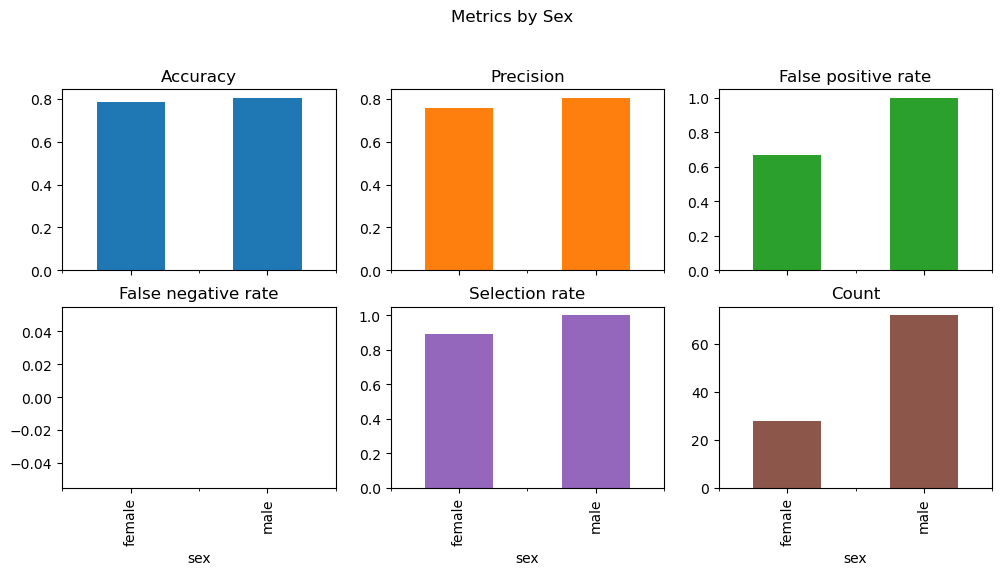

In [98]:
# Plot metrics using MetricFrame
mlp_metrics = {
    "Accuracy": accuracy_score,
    "Precision": precision_score,
    "False positive rate": false_positive_rate,
    "False negative rate": false_negative_rate,
    "Selection rate": selection_rate,
    "Count": count,
}

mlp_metric_frame = MetricFrame(
    metrics=mlp_metrics, y_true=y_test, y_pred=mlp_preds, sensitive_features=A_test
)

# Plotting
mlp_metric_frame.by_group.plot.bar(
    subplots=True,
    layout=[3, 3],
    legend=False,
    figsize=[12, 8],
    title="Metrics by Sex",
)

In [99]:
# Some "difference" metrics (as in Nils' paper)
display(Markdown("#### Raw values")) 

# Accuracy difference
mlp_accuracy_values = mlp_metric_frame.by_group["Accuracy"]
mlp_acc_diff = mlp_accuracy_values.max() - mlp_accuracy_values.min()
print(f"Accuracy difference: {mlp_acc_diff:.4f}")

# Precision difference
mlp_precision_values = mlp_metric_frame.by_group["Precision"]
mlp_prec_diff = mlp_precision_values.max() - mlp_precision_values.min()
print(f"Precision difference: {mlp_prec_diff:.4f}")

# True positive rate (TPR) difference
# tpr_diff = true_positive_rate_difference(y_true=y_test, y_pred=y_pred, sensitive_features=A_test) # still work but not seen in current version of fairlearn
mlp_tpr_values = 1 - mlp_metric_frame.by_group["False negative rate"]
mlp_tpr_diff = mlp_tpr_values.max() - mlp_tpr_values.min() 
print(f"True positive rate difference: {mlp_tpr_diff:.4f}")

# False positive rate (FPR) difference
# fpr_diff = false_positive_rate_difference(y_true=y_test, y_pred=y_pred, sensitive_features=A_test) # still work but not seen in current version of fairlearn
mlp_fpr_values = mlp_metric_frame.by_group["False positive rate"]
mlp_fpr_diff = mlp_fpr_values.max() - mlp_fpr_values.min()
print(f"False positive rate difference: {mlp_fpr_diff:.4f}")

# Demographic parity (DemP) difference
mlp_dp_diff = demographic_parity_difference(y_true=y_test, y_pred=mlp_preds, sensitive_features=A_test)
print(f"Demographic parity difference: {mlp_dp_diff:.4f}")

# Equalized odds (EO) difference
# Defined as the greater of the 2 metrics: TPR difference and the FPR difference: max(tpr_diff, fpr_diff)
# Currently, this is the same as the TPR difference
mlp_eo_diff = equalized_odds_difference(y_true=y_test, y_pred=mlp_preds, sensitive_features=A_test)
print(f"Equalized odds difference: {mlp_eo_diff:.4f}")

#### Raw values

Accuracy difference: 0.0198
Precision difference: 0.0456
True positive rate difference: 0.0000
False positive rate difference: 0.3333
Demographic parity difference: 0.1071
Equalized odds difference: 0.3333


### TabResNet

array([[<Axes: title={'center': 'Accuracy'}, xlabel='sex'>,
        <Axes: title={'center': 'Precision'}, xlabel='sex'>,
        <Axes: title={'center': 'False positive rate'}, xlabel='sex'>],
       [<Axes: title={'center': 'False negative rate'}, xlabel='sex'>,
        <Axes: title={'center': 'Selection rate'}, xlabel='sex'>,
        <Axes: title={'center': 'Count'}, xlabel='sex'>],
       [<Axes: xlabel='sex'>, <Axes: xlabel='sex'>, <Axes: xlabel='sex'>]],
      dtype=object)

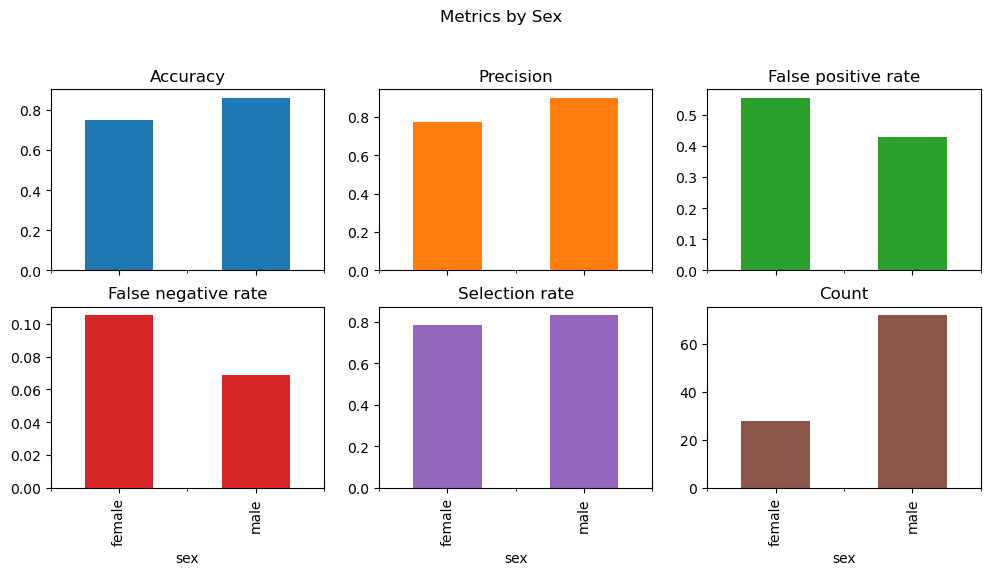

In [80]:
# Plot metrics using MetricFrame
metrics = {
    "Accuracy": accuracy_score,
    "Precision": precision_score,
    "False positive rate": false_positive_rate,
    "False negative rate": false_negative_rate,
    "Selection rate": selection_rate,
    "Count": count,
}

metric_frame = MetricFrame(
    metrics=metrics, y_true=y_test, y_pred=preds, sensitive_features=A_test
)

# Plotting
metric_frame.by_group.plot.bar(
    subplots=True,
    layout=[3, 3],
    legend=False,
    figsize=[12, 8],
    title="Metrics by Sex",
)

In [81]:
# Some "difference" metrics (as in Nils' paper)
display(Markdown("#### Raw values")) 

# Accuracy difference
accuracy_values = metric_frame.by_group["Accuracy"]
acc_diff = accuracy_values.max() - accuracy_values.min()
print(f"Accuracy difference: {acc_diff:.4f}")

# Precision difference
precision_values = metric_frame.by_group["Precision"]
prec_diff = precision_values.max() - precision_values.min()
print(f"Precision difference: {prec_diff:.4f}")

# True positive rate (TPR) difference
# tpr_diff = true_positive_rate_difference(y_true=y_test, y_pred=y_pred, sensitive_features=A_test) # still work but not seen in current version of fairlearn
tpr_values = 1 - metric_frame.by_group["False negative rate"]
tpr_diff = tpr_values.max() - tpr_values.min() 
print(f"True positive rate difference: {tpr_diff:.4f}")

# False positive rate (FPR) difference
# fpr_diff = false_positive_rate_difference(y_true=y_test, y_pred=y_pred, sensitive_features=A_test) # still work but not seen in current version of fairlearn
fpr_values = metric_frame.by_group["False positive rate"]
fpr_diff = fpr_values.max() - fpr_values.min()
print(f"False positive rate difference: {fpr_diff:.4f}")

# Demographic parity (DemP) difference
dp_diff = demographic_parity_difference(y_true=y_test, y_pred=preds, sensitive_features=A_test)
print(f"Demographic parity difference: {dp_diff:.4f}")

# Equalized odds (EO) difference
# Defined as the greater of the 2 metrics: TPR difference and the FPR difference: max(tpr_diff, fpr_diff)
# Currently, this is the same as the TPR difference
eo_diff = equalized_odds_difference(y_true=y_test, y_pred=preds, sensitive_features=A_test)
print(f"Equalized odds difference: {eo_diff:.4f}")

#### Raw values

Accuracy difference: 0.1111
Precision difference: 0.1273
True positive rate difference: 0.0363
False positive rate difference: 0.1270
Demographic parity difference: 0.0476
Equalized odds difference: 0.1270
